In [6]:
import pandas as pd
from typing import List, Dict, Any
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# url_restauration = "https://www.pxweb.bfs.admin.ch/sq/3c431fe1-16b0-4572-a8cd-ddbcfc919c5f"
url_restauration = "https://www.pxweb.bfs.admin.ch/sq/ac42fe01-72e8-4c55-9ab2-b997e87b1fa1"
url_population = "https://www.pxweb.bfs.admin.ch/sq/a2f3f03c-3b76-4dc0-890e-c6534d341848"

def restauration_employement_to_population_ratio(url_restauration : str, url_population : str) -> pd.DataFrame:
    df_restauration = pd.read_csv(url_restauration, encoding="ANSI")
    df_population = pd.read_csv(url_population, encoding="ANSI")
    df_population = df_population.groupby(["Année", "Sexe"], as_index=False)["Effectif au 1er janvier"].agg("sum")
    
    years : List[int] = [i for i in range(2010, 2025) for _ in range(8)]
    quarters : List[int] = [i for _ in range(15*2) for i in range(1, 5)]
    female : List[int] = [i for _ in range(15) for i in [1]*4+[0]*4]  # 1 if female, 0 if male
    indexes_of_columns_to_go : List[int] = [2+i for j in range((df_restauration.shape[1]-3)//4) for _ in range(2) for i in range(4*j+1, 4*j+5)] #to search efficiently in the dataframe for having the final dataframe in the right format easily
    y : List[float] = []

    for index, gender, year in zip(indexes_of_columns_to_go, female, years):
        y.append(df_restauration.iloc[gender, index]/df_population.loc[df_population["Année"].eq(year)&df_population["Sexe"].eq("Femme" if gender==1 else "Homme"), "Effectif au 1er janvier"].iat[0]*100)

    dict : Dict[List[Any]] = {"Year" : years,
            "Quarter" : quarters,
            "Employment-to-population Ratio [%]" : y, 
            "Female" : female}
    return pd.DataFrame(dict)

def create_quarter_dummies(df : pd.DataFrame):
    quarter_lists_list = [[], [], [], []]
    for i in range(df.shape[0]):
        for j in range(1, 5):
            if df["Quarter"][i]==j:
                quarter_lists_list[j-1].append(1)
            else:
                quarter_lists_list[j-1].append(0)
    for i in range(4):
        df[f"Q{i+1}"]=quarter_lists_list[i]
    return df

def create_before_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    df["Before_Lockdown"] = [1 if i<80 else 0 for i in range(df.shape[0])]
    return df

def create_lockdown_dummies(df : pd.DataFrame, include_after : bool = False) -> pd.DataFrame:
    indexes = [i for i in range(80, 98)]
    if include_after:
        indexes.extend([i for i in range(98, df.shape[0])])
    else:
        indexes.extend([100, 101])
    dummy_list = [1 if i in indexes else 0 for i in range(df.shape[0])]
    df[f"{"After_" if include_after else "During_"}Lockdown"] = dummy_list
    return df

def create_not_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    indexes = [i for i in range(80, 98)]
    indexes.extend([100, 101])
    dummy_list = [0 if i in indexes else 1 for i in range(df.shape[0])]
    df["Not_Covid"] = dummy_list
    return df

def create_after_lockdown_dummies(df: pd.DataFrame) -> pd.DataFrame:
    indexes_list = [98, 99]
    indexes_list.extend(i for i in range(102, df.shape[0]))
    dummy_list = [1 if i in indexes_list else 0 for i in range(df.shape[0])]
    df["After_End_Measures"] = dummy_list
    return df

def create_years_pre_post_dummies(df : pd.DataFrame) -> pd.DataFrame:
    oyb_dummies = [1 if 72<=i<80 else 0 for i in range(df.shape[0])]
    tyb_dummies = [1 if 64<=i<72 else 0 for i in range(df.shape[0])]
    oya_dummies = [1 if i in [98, 99, 102, 103, 104, 105, 108, 109] else 0 for i in range(df.shape[0])]
    tya_dummies = [1 if i in [106, 107, 110, 111, 112, 113, 114, 115] else 0 for i in range(df.shape[0])]
    df["Two_Year_Before"] = tyb_dummies
    df["One_Year_Before"] = oyb_dummies
    df["One_Year_After"] = oya_dummies
    df["Two_Year_After"] = tya_dummies
    return df

def dataframe_creator(url_restauration : str, url_population : str) -> pd.DataFrame:
    df = restauration_employement_to_population_ratio(url_restauration, url_population)
    df = create_quarter_dummies(df)
    df = create_before_lockdown_dummies(df)
    df = create_lockdown_dummies(df)
    df = create_not_lockdown_dummies(df)
    df = create_lockdown_dummies(df, True)
    df = create_after_lockdown_dummies(df)
    df = create_years_pre_post_dummies(df)
    return df

In [17]:
df = pd.read_csv(url_restauration, encoding="ANSI")
df

,Division économique,Taux d'occupation,Sexe,2010Q1,2010Q2,2010Q3,2010Q4,2011Q1,2011Q2,2011Q3,...,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4,2024Q1,2024Q2,2024Q3,2024Q4
0,56 Restauration,Taux d'occupation - total,Homme,81081,80037,79297,78369,78183,77380,74144,...,89362,88793,91767,93571,97837,93143,93380,94986,92975,97660
1,56 Restauration,Taux d'occupation - total,Femme,106241,105617,105739,102399,101770,104322,100500,...,94536,97280,96330,98853,103042,99743,98966,96935,94124,95822


In [18]:
df = dataframe_creator(url_restauration, url_population)
df

,Year,Quarter,Employment-to-population Ratio [%],Female,Q1,Q2,Q3,Q4,Before_Lockdown,During_Lockdown,Not_Covid,After_Lockdown,After_End_Measures,Two_Year_Before,One_Year_Before,One_Year_After,Two_Year_After
0,2010,1,3.103141,1,1,0,0,0,1,0,1,0,0,0,0,0,0
1,2010,2,3.084915,1,0,1,0,0,1,0,1,0,0,0,0,0,0
2,2010,3,3.088478,1,0,0,1,0,1,0,1,0,0,0,0,0,0
3,2010,4,2.990922,1,0,0,0,1,1,0,1,0,0,0,0,0,0
4,2010,1,2.482187,0,1,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024,4,2.456345,1,0,0,0,1,0,0,1,1,1,0,0,0,1
116,2024,1,2.452151,0,1,0,0,0,0,0,1,1,1,0,0,0,0
117,2024,2,2.494324,0,0,1,0,0,0,0,1,1,1,0,0,0,0
118,2024,3,2.441515,0,0,0,1,0,0,0,1,1,1,0,0,0,0


In [19]:
df.to_csv("df.csv", index=False)

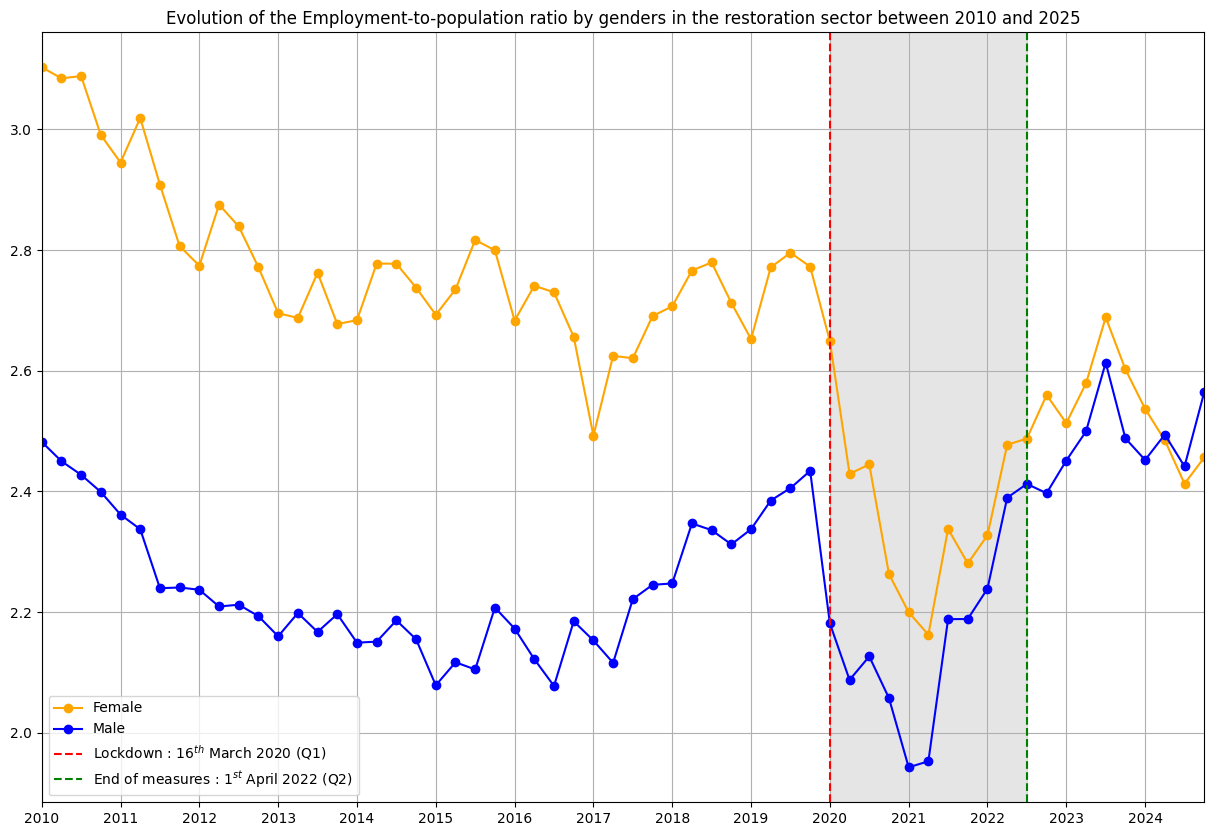

In [20]:
time = np.linspace(0, 59, 60)
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"], c="orange", marker="o", label="Female")
ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"], c="blue", marker="o", label="Male")
ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
ax.axvline(50, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
ax.axvspan(40, 50, color="grey", alpha=0.2)
plt.xlim(0, 59)
plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
plt.legend()
plt.grid()
plt.title("Evolution of the Employment-to-population ratio by genders in the restoration sector between 2010 and 2025")
plt.show()

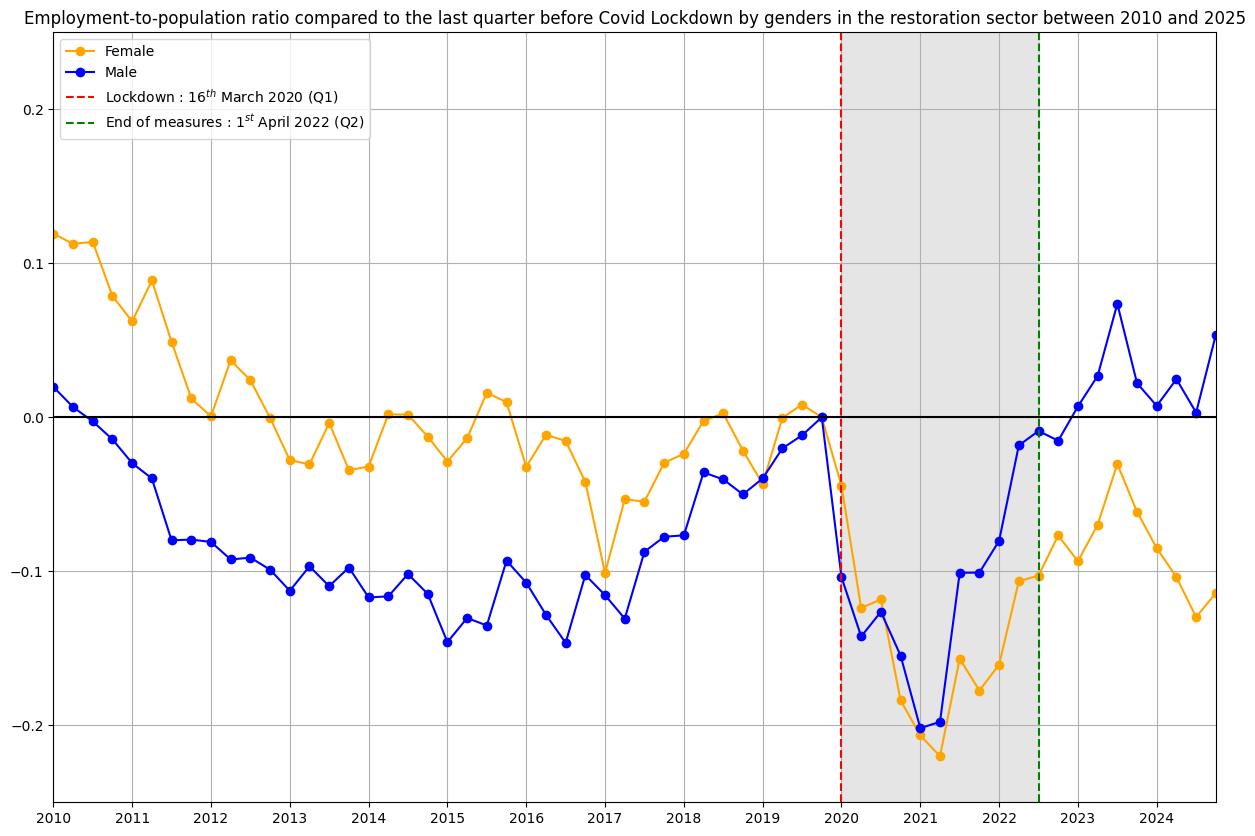

In [29]:
before_covid_female = df.iloc[75, 2]
before_covid_male = df.iloc[79, 2]

time = np.linspace(0, 59, 60)
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_female-1, c="orange", marker="o", label="Female")
ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_male-1, c="blue", marker="o", label="Male")
ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
ax.axvline(50, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
ax.axvspan(40, 50, color="grey", alpha=0.2)
ax.hlines(0, xmin=0, xmax=59, color="k")
plt.xlim(0, 59)
plt.ylim(-0.25, 0.25)
plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
plt.legend()
plt.grid()
plt.title("Employment-to-population ratio compared to the last quarter before Covid Lockdown by genders in the restoration sector between 2010 and 2025")
plt.show()

## DiDs

### Formulas

In [30]:
# DiDs
formula_did_a = r"Q('Employment-to-population Ratio [%]') ~ Female + After_Lockdown + Female:After_Lockdown"
formula_did_b = r"Q('Employment-to-population Ratio [%]') ~ Female + During_Lockdown + Female:During_Lockdown"
formula_did_quarter = r"Q('Employment-to-population Ratio [%]') ~ Female + During_Lockdown + Female:During_Lockdown + C(Quarter)"

In [31]:
simple_did = smf.ols(formula_did_a, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.730
Model:                                                 OLS   Adj. R-squared:                  0.723
Method:                                      Least Squares   F-statistic:                     129.6
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           6.94e-37
Time:                                             16:14:44   Log-Likelihood:                 64.862
No. Observations:                                      120   AIC:                            -121.7
Df Residuals:                                          116   BIC:                            -110.6
Df Model:                                                3                                         
Covariance Type:                                       HC1                                         


In [32]:
# formula_did = '''
# Q("Employment-to-population Ratio [%]") ~ Female + policy_period + Female:policy_period + C(Year) + C(Quarters)'''

simple_did = smf.ols(formula_did_b, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.708
Model:                                                 OLS   Adj. R-squared:                  0.701
Method:                                      Least Squares   F-statistic:                     92.54
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           1.22e-30
Time:                                             16:14:46   Log-Likelihood:                 60.137
No. Observations:                                      120   AIC:                            -112.3
Df Residuals:                                          116   BIC:                            -101.1
Df Model:                                                3                                         
Covariance Type:                                       HC1                                         


In [33]:
simple_did = smf.ols(formula_did_quarter, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.710
Model:                                                 OLS   Adj. R-squared:                  0.695
Method:                                      Least Squares   F-statistic:                     46.07
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           3.74e-28
Time:                                             16:14:49   Log-Likelihood:                 60.525
No. Observations:                                      120   AIC:                            -107.1
Df Residuals:                                          113   BIC:                            -87.54
Df Model:                                                6                                         
Covariance Type:                                       HC1                                         


In [34]:
formula_did_c = r"Q('Employment-to-population Ratio [%]') ~ Female + Not_Covid + Female:Not_Covid"

simple_did = smf.ols(formula_did_c, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.708
Model:                                                 OLS   Adj. R-squared:                  0.701
Method:                                      Least Squares   F-statistic:                     92.54
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           1.22e-30
Time:                                             16:15:06   Log-Likelihood:                 60.137
No. Observations:                                      120   AIC:                            -112.3
Df Residuals:                                          116   BIC:                            -101.1
Df Model:                                                3                                         
Covariance Type:                                       HC1                                         


In [35]:
formula_did_d = r"Q('Employment-to-population Ratio [%]') ~ Female + Before_Lockdown + After_End_Measures + Female:Before_Lockdown + Female:After_End_Measures"

simple_did = smf.ols(formula_did_d, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.815
Model:                                                 OLS   Adj. R-squared:                  0.807
Method:                                      Least Squares   F-statistic:                     89.62
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           7.65e-38
Time:                                             16:15:09   Log-Likelihood:                 87.599
No. Observations:                                      120   AIC:                            -163.2
Df Residuals:                                          114   BIC:                            -146.5
Df Model:                                                5                                         
Covariance Type:                                       HC1                                         


In [36]:
formula_did_e = r"Q('Employment-to-population Ratio [%]') ~ Female + After_End_Measures + Female:After_End_Measures"

simple_did = smf.ols(formula_did_e, data=df.loc[df["During_Lockdown"]==0]).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.819
Model:                                                 OLS   Adj. R-squared:                  0.813
Method:                                      Least Squares   F-statistic:                     127.0
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           2.67e-33
Time:                                             16:15:12   Log-Likelihood:                 76.083
No. Observations:                                      100   AIC:                            -144.2
Df Residuals:                                           96   BIC:                            -133.7
Df Model:                                                3                                         
Covariance Type:                                       HC1                                         


In [37]:
formula_did_e_heavy = formula_did_e + " + C(Quarter) + Female:C(Quarter)"
print(formula_did_e_heavy)
simple_did = smf.ols(formula_did_e_heavy, data=df.loc[df["During_Lockdown"]==0]).fit(cov_type="HC1")
print(simple_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + After_End_Measures + Female:After_End_Measures + C(Quarter) + Female:C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.823
Model:                                                 OLS   Adj. R-squared:                  0.806
Method:                                      Least Squares   F-statistic:                     45.18
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           1.31e-29
Time:                                             16:15:15   Log-Likelihood:                 77.318
No. Observations:                                      100   AIC:                            -134.6
Df Residuals:                                           90   BIC:                            -108.6
Df Model:                                                9           

In [38]:
formula_did_e_heavy = formula_did_e + " + C(Quarter) + C(Year) + Female:C(Quarter) + Female:C(Year)"
simple_did = smf.ols(formula_did_e_heavy, data=df.loc[df["During_Lockdown"]==0]).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.975
Model:                                                 OLS   Adj. R-squared:                  0.964
Method:                                      Least Squares   F-statistic:                     260.0
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           1.81e-59
Time:                                             16:15:18   Log-Likelihood:                 175.13
No. Observations:                                      100   AIC:                            -286.3
Df Residuals:                                           68   BIC:                            -202.9
Df Model:                                               31                                         
Covariance Type:                                       HC1                                         


c:\Users\julie\anaconda3\envs\datascience_causalinference\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  warnings.warn('covariance of constraints does not have full '


In [47]:
df.loc[df["During_Lockdown"]==0]

,Year,Quarter,Employment-to-population Ratio [%],Female,Q1,Q2,Q3,Q4,Before_Lockdown,During_Lockdown,...,After_Lockdown,After_End_Measures,Y2019Q4,Y2019Q3,Y2019Q2,Y2019Q1,Y2022Q3,Y2022Q4,Y2023Q1,Y2023Q2
0,2010,1,3.084915,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2010,2,3.088478,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,3,2.990922,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2010,4,2.972550,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2010,1,2.450227,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024,4,2.385542,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
116,2024,1,2.494324,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
117,2024,2,2.441515,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
118,2024,3,2.564543,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0


## Event Studies

### Formulas

In [39]:
# formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female  + Y2019Q3 + Y2019Q4 + During_Lockdown + Y2022Q3 + Y2022Q4  + Female:Y2019Q3 + Female:Y2019Q2 + Female:During_Lockdown + Female:Y2022Q3 + Female:Y2022Q4"
# formula_es_heavier = r"Q('Employment-to-population Ratio [%]') ~ Female + C(Period, Treatment(reference=0)) + C(Quarter)"
formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female + Y2019Q4 + Y2019Q3 + Y2019Q2 + Y2019Q1 + During_Lockdown + Y2022Q3 + Y2022Q4 + Y2023Q1 + Y2023Q2 + Female:Y2019Q4 + Female:Y2019Q3 + Female:Y2019Q2 + Female:Y2019Q1 + Female:During_Lockdown + Female:Y2022Q3 + Female:Y2022Q4 + Female:Y2023Q1 + Female:Y2023Q2"
formula_es_heavier =formula_es_simple + " + C(Quarter)"

### With 4 quarters before and after the Covid era -> multicolinearity issues

In [40]:
# formula_eventstudy = r'''Q("Employment-to-population Ratio [%]") ~ Female + C(Year) + C(Quarters) + C(event_time, Treatment(reference=-1)):Female'''
print(formula_es_simple)
eventstudy_did = smf.ols(formula_es_simple, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Y2019Q4 + Y2019Q3 + Y2019Q2 + Y2019Q1 + During_Lockdown + Y2022Q3 + Y2022Q4 + Y2023Q1 + Y2023Q2 + Female:Y2019Q4 + Female:Y2019Q3 + Female:Y2019Q2 + Female:Y2019Q1 + Female:During_Lockdown + Female:Y2022Q3 + Female:Y2022Q4 + Female:Y2023Q1 + Female:Y2023Q2


PatsyError: Error evaluating factor: NameError: name 'Y2019Q4' is not defined
    Q('Employment-to-population Ratio [%]') ~ Female + Y2019Q4 + Y2019Q3 + Y2019Q2 + Y2019Q1 + During_Lockdown + Y2022Q3 + Y2022Q4 + Y2023Q1 + Y2023Q2 + Female:Y2019Q4 + Female:Y2019Q3 + Female:Y2019Q2 + Female:Y2019Q1 + Female:During_Lockdown + Female:Y2022Q3 + Female:Y2022Q4 + Female:Y2023Q1 + Female:Y2023Q2
                                                       ^^^^^^^

### With ony 1 quarter before and after the Covid era and the quarter fixed effects -> multicolinearity issues

In [20]:
formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female + Y2019Q1 + During_Lockdown + Y2022Q3 + Female:Y2019Q1 + Female:During_Lockdown + Female:Y2022Q3"
formula_es_heavier =formula_es_simple + " + C(Quarter)"

eventstudy_did = smf.ols(formula_es_heavier, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.719
Model:                                                 OLS   Adj. R-squared:                  0.693
Method:                                      Least Squares   F-statistic:                     20.62
Date:                                   lun., 15 déc. 2025   Prob (F-statistic):           1.98e-17
Time:                                             16:16:40   Log-Likelihood:                 65.312
No. Observations:                                      120   AIC:                            -108.6
Df Residuals:                                          109   BIC:                            -77.96
Df Model:                                               10                                         
Covariance Type:                                       HC1                                         


c:\Users\julie\anaconda3\envs\datascience_causalinference\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 7
  warnings.warn('covariance of constraints does not have full '


### Only before/during/after lockdown comparative (no fixed effects) -> no multicoliearity issues

In [41]:
formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female + During_Lockdown + After_End_Measures + Female:During_Lockdown + Female:After_End_Measures"
formula_es_heavier =formula_es_simple + " + C(Quarter)"

eventstudy_did = smf.ols(formula_es_simple, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.815
Model:                                                 OLS   Adj. R-squared:                  0.807
Method:                                      Least Squares   F-statistic:                     89.62
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           7.65e-38
Time:                                             16:15:46   Log-Likelihood:                 87.599
No. Observations:                                      120   AIC:                            -163.2
Df Residuals:                                          114   BIC:                            -146.5
Df Model:                                                5                                         
Covariance Type:                                       HC1                                         


In [42]:
eventstudy_did = smf.ols(formula_es_heavier, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.817
Model:                                                 OLS   Adj. R-squared:                  0.804
Method:                                      Least Squares   F-statistic:                     56.24
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           1.48e-35
Time:                                             16:16:03   Log-Likelihood:                 88.217
No. Observations:                                      120   AIC:                            -158.4
Df Residuals:                                          111   BIC:                            -133.3
Df Model:                                                8                                         
Covariance Type:                                       HC1                                         


### Solution by Quentin Gallea

In [44]:
formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female + One_Year_Before + During_Lockdown + One_Year_After + Female:One_Year_Before + Female:During_Lockdown + Female:One_Year_After"
formula_es_heavier =formula_es_simple + " + C(Quarter)"

print(formula_es_simple)
eventstudy_did = smf.ols(formula_es_simple, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + One_Year_Before + During_Lockdown + One_Year_After + Female:One_Year_Before + Female:During_Lockdown + Female:One_Year_After
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.744
Model:                                                 OLS   Adj. R-squared:                  0.728
Method:                                      Least Squares   F-statistic:                     56.93
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           5.35e-34
Time:                                             16:16:30   Log-Likelihood:                 68.050
No. Observations:                                      120   AIC:                            -120.1
Df Residuals:                                          112   BIC:                            -97.80
Df Model:               

In [45]:
print(formula_es_heavier)
eventstudy_did = smf.ols(formula_es_heavier, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + One_Year_Before + During_Lockdown + One_Year_After + Female:One_Year_Before + Female:During_Lockdown + Female:One_Year_After + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.746
Model:                                                 OLS   Adj. R-squared:                  0.723
Method:                                      Least Squares   F-statistic:                     43.19
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           2.20e-33
Time:                                             16:16:33   Log-Likelihood:                 68.495
No. Observations:                                      120   AIC:                            -115.0
Df Residuals:                                          109   BIC:                            -84.33
Df Model:  

In [46]:
formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female + Two_Year_Before + One_Year_Before + During_Lockdown + One_Year_After + Two_Year_After + Female:Two_Year_Before + Female:One_Year_Before + Female:During_Lockdown + Female:One_Year_After + Female:Two_Year_After"
formula_es_heavier =formula_es_simple + " + C(Quarter)"

print(formula_es_simple)
eventstudy_did = smf.ols(formula_es_simple, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Two_Year_Before + One_Year_Before + During_Lockdown + One_Year_After + Two_Year_After + Female:Two_Year_Before + Female:One_Year_Before + Female:During_Lockdown + Female:One_Year_After + Female:Two_Year_After
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.804
Model:                                                 OLS   Adj. R-squared:                  0.784
Method:                                      Least Squares   F-statistic:                     66.44
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           6.83e-43
Time:                                             16:16:36   Log-Likelihood:                 83.884
No. Observations:                                      120   AIC:                            -143.8
Df Residuals:                           

In [47]:
print(formula_es_heavier)
eventstudy_did = smf.ols(formula_es_heavier, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Two_Year_Before + One_Year_Before + During_Lockdown + One_Year_After + Two_Year_After + Female:Two_Year_Before + Female:One_Year_Before + Female:During_Lockdown + Female:One_Year_After + Female:Two_Year_After + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.805
Model:                                                 OLS   Adj. R-squared:                  0.779
Method:                                      Least Squares   F-statistic:                     76.25
Date:                                   mar., 16 déc. 2025   Prob (F-statistic):           2.38e-48
Time:                                             16:16:38   Log-Likelihood:                 84.449
No. Observations:                                      120   AIC:                            -138.9
Df Residuals:              

                                            Year       Quarter  \
Year                                1.000000e+00  5.883853e-16   
Quarter                             5.883853e-16  1.000000e+00   
Employment-to-population Ratio [%] -2.302561e-01  3.845031e-02   
Female                             -5.867406e-15  2.648036e-17   
Q1                                 -1.164130e-15 -7.745967e-01   
Q2                                  4.243090e-16 -2.581989e-01   
Q3                                 -3.778229e-16  2.581989e-01   
Q4                                  1.115666e-15  7.745967e-01   
Before_Lockdown                    -8.183171e-01  4.599192e-16   
During_Lockdown                     3.933374e-01 -8.000000e-02   
Not_Covid                          -3.933374e-01  8.000000e-02   
After_Lockdown                      8.183171e-01 -4.423650e-16   
After_End_Measures                  6.417610e-01  8.000000e-02   
Two_Year_Before                     6.185896e-02 -9.910810e-17   
One_Year_B

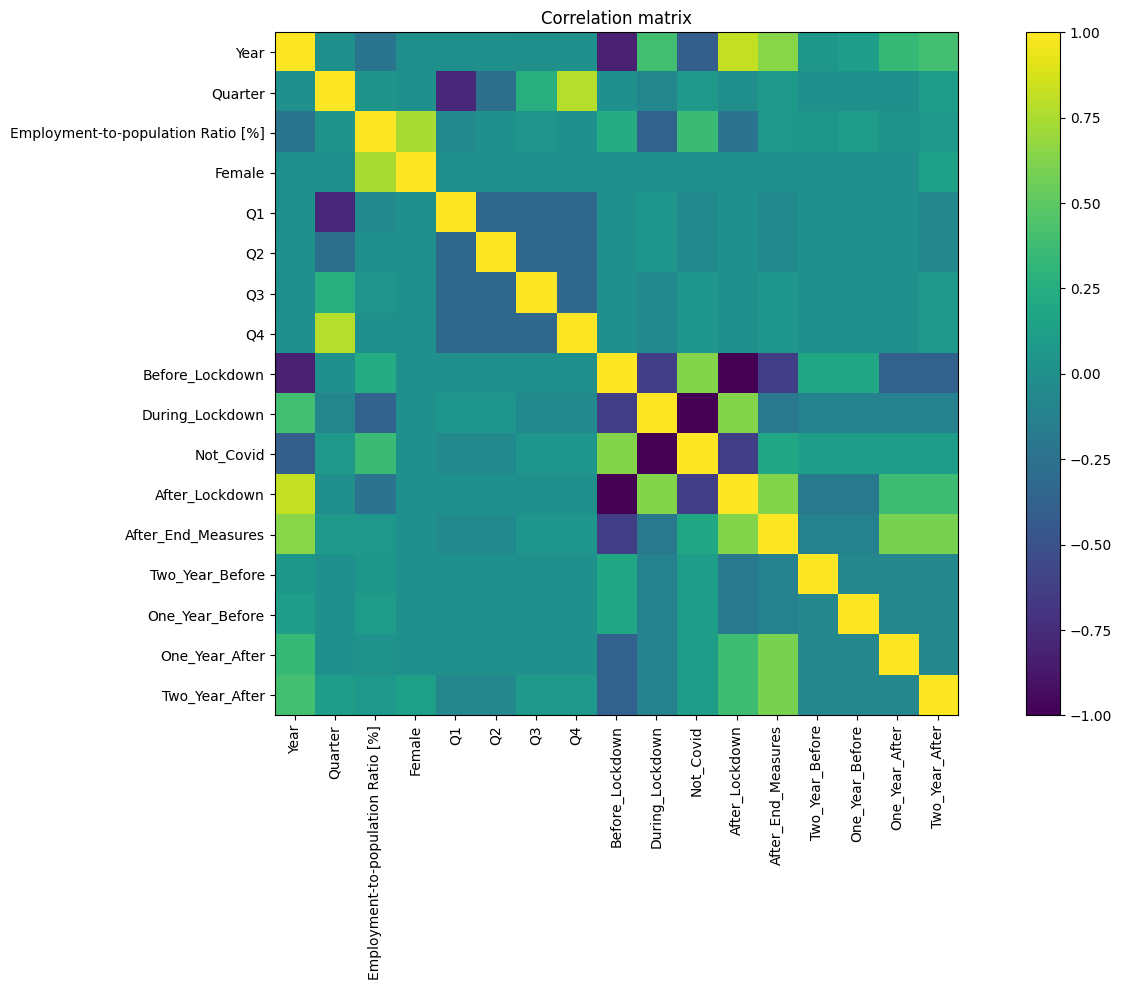

In [48]:
# import pandas as pd
# import matplotlib.pyplot as plt

# correlation (Pearson by default) between numeric columns
corr = df.corr(numeric_only=True)

print(corr)  # or display(corr) in a notebook

# visualize
plt.figure(figsize=(15, 10))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

In [58]:
df.columns

Index(['Year', 'Quarter', 'Employment-to-population Ratio [%]', 'Female', 'Q1',
       'Q2', 'Q3', 'Q4', 'Before_Lockdown', 'During_Lockdown', 'Not_Covid',
       'After_Lockdown', 'After_End_Measures', 'Y2019Q4', 'Y2019Q3', 'Y2019Q2',
       'Y2019Q1', 'Y2022Q3', 'Y2022Q4', 'Y2023Q1', 'Y2023Q2'],
      dtype='object')

In [61]:
df.describe()

,Year,Quarter,Employment-to-population Ratio [%],Female,Q1,Q2,Q3,Q4,Before_Lockdown,During_Lockdown,...,After_Lockdown,After_End_Measures,Y2019Q4,Y2019Q3,Y2019Q2,Y2019Q1,Y2022Q3,Y2022Q4,Y2023Q1,Y2023Q2
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2017.000000,2.500000,2.467453,0.500000,0.250000,0.250000,0.250000,0.250000,0.666667,0.166667,...,0.333333,0.166667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667
std,4.338609,1.122722,0.265985,0.502096,0.434828,0.434828,0.434828,0.434828,0.473381,0.374241,...,0.473381,0.374241,0.128556,0.128556,0.128556,0.128556,0.128556,0.128556,0.128556,0.128556
min,2010.000000,1.000000,1.952704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.000000,1.750000,2.214198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,2.500000,2.443126,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2021.000000,3.250000,2.709619,1.000000,0.250000,0.250000,0.250000,0.250000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,4.000000,3.088478,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
mean_female_before = df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"].describe()
mean_male_before = df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"].describe()
# mean_female_after = df.loc[df["Female"]==1 & df["After_End_Measures"]==1, "Employment-to-population Ratio [%]"].mean()
# mean_male_after = df.loc[df["Female"]==0 & df["After_End_Measures"]==1, "Employment-to-population Ratio [%]"].mean()
# print(f"Female: {mean_female_before, mean_female_after}")
# print(f"Male: {mean_male_before, mean_male_after}")
print(mean_female_before)
print("")
print(mean_male_before)

count    60.000000
mean      2.662828
std       0.205029
min       2.162529
25%       2.529695
50%       2.710611
75%       2.777570
max       3.088478
Name: Employment-to-population Ratio [%], dtype: float64

count    60.000000
mean      2.272079
std       0.151730
min       1.952704
25%       2.179218
50%       2.230597
75%       2.397620
max       2.613419
Name: Employment-to-population Ratio [%], dtype: float64


In [13]:
url_restauration = "https://www.pxweb.bfs.admin.ch/sq/2a5a7e1f-b020-4e6e-825e-37e9fc2a494f"
df1 = pd.read_csv(url_restauration, encoding="ANSI")
df1

,Division économique,Taux d'occupation,Sexe,2010Q1,2010Q2,2010Q3,2010Q4,2011Q1,2011Q2,2011Q3,...,2023Q2,2023Q3,2023Q4,2024Q1,2024Q2,2024Q3,2024Q4,2025Q1,2025Q2,2025Q3
0,56 Restauration,Taux d'occupation - total,Homme,81081,80037,79297,78369,78183,77380,74144,...,93571,97837,93143,93380,94986,92975,97660,96488,94265,94505
1,56 Restauration,Taux d'occupation - total,Femme,106241,105617,105739,102399,101770,104322,100500,...,98853,103042,99743,98966,96935,94124,95822,93060,95432,96445
